In [1]:
# improting relevant packages

# generic
import numpy as np
import pandas as pd

# for training models 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# pickling models
import joblib

# finding best model
from sklearn.model_selection import GridSearchCV, cross_val_score

# plots
import plotly.express as px

# packages for model evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

First we will import our preprocessed data and our target variable

In [2]:
# loading the data
df = pd.read_parquet('../data/cleaned/dataCleanWMedicalUrgency.parquet')

# saetting y to be the target variable
y = df['medical_urgency']

# importing the preprocessed data
X = pd.read_parquet('../data/cleaned/featuresPreprocessed.parquet')


Now we will split the data into remainder data and testig data. We will keep the test data separate and only use it for testing purposes. 

We will train on 75% of the data and leave 25% to test on. Our test set will be a random sample stratified by velues in the target variable, y, so as to keep proportional representation of each value in y.

We will measure the success of our models by their accuracy scores on the test data.

In [3]:
# splitting the data
X_rem, X_test, y_rem, y_test = train_test_split(X, y, test_size=0.25, random_state=1234, stratify=y)

# resetting indices to allow models to run properly
X_rem.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_rem.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

We will quickly check the accuracy score of a naive model that predicts the mode of y.

In [5]:
# checking proportions of each value in y
y.value_counts() / len(y) 

medical_urgency
1    0.423311
0    0.302515
2    0.274174
Name: count, dtype: float64

1 is the most common value in the target variable. A naive model that guesses 1 every time would have an accuracy of 42.33%

# Initial logistic regression model

Our first model will be a logistic regression. It will be a baseline and hopefully give us a starting point for further models and optimisation.It will be basic and will not use cross validation. Its purpose it just to light the way for future models.

Let's make our first model. We will use a pipeline that includes scaling. The parameters for the logistic regression are set more or less at random, providing starting points for future models. 

In [6]:
# setting up the estimators 
estimators = [
    ('normalise', StandardScaler()),
    ('log', LogisticRegression(C=0.1, max_iter=10000))
]

# making the pipeline
pipe = Pipeline(estimators)

Time to fit the model to the remainder set.

In [7]:
# fitting the pipeline model to the remainder data
pipe.fit(X_rem, y_rem)

Pipeline(steps=[('normalise', StandardScaler()),
                ('log', LogisticRegression(C=0.1, max_iter=10000))])

Let's pint the accuracy scores and see how the model did.

In [8]:
# printing the logistic regression model's accuracy score for the remainder set and the test set
print(pipe.score(X_rem, y_rem))
print(pipe.score(X_test, y_test))

0.7414550535094415
0.73941161643441


We have achieved 74.15% accuracy on the remainder set, and 73.94% accuracy on the test set. This is a significant imporovement on 42.33% (training accuracy) for the naive model. Hopefully we can do even better during model optimisation.

We would like to achive two things with our model. One is to accurately predict medical urgency score. The other is to determine the most influential factors to medical urgency score. The latter requires us to use a logistic regression model and to analyse the coefficients of the model. The former we can achieve by optimising over different types of models. 

We will start by optimising a logistic regression model.

Let's pickle our model so that we can access it in the future.

In [9]:
# saving the model
joblib.dump(pipe, '../model/logistic_model_1.pkl')

['../model/logistic_model_1.pkl']

# Optimising the logistic regression model

Including code to reload data below so it is reasy to load the same remainder and test set in case of restarting kernels. This code includes making an experimental set X_esp and y_exp to run code on to check for bugs before running models on X_rem and y_rem, which takes a lot of time. 

In [10]:
# loading the data
df = pd.read_parquet('../data/cleaned/dataCleanWMedicalUrgency.parquet')

# saetting y to be the target variable
y = df['medical_urgency']

# importing the preprocessed data
X = pd.read_parquet('../data/cleaned/featuresPreprocessed.parquet')

# splitting the data
X_rem, X_test, y_rem, y_test = train_test_split(X, y, test_size=0.25, random_state=1234, stratify=y)

# resetting indices to allow models to run properly
X_rem.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_rem.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# making an experimental dataframe that has 10% of the rows of X_rem
X_exp, X_bin, y_exp, y_bin = train_test_split(X_rem, y_rem, test_size=0.999, random_state=1234, stratify=y_rem)

#resetting indices
X_exp.reset_index(drop=True, inplace=True)
y_exp.reset_index(drop=True, inplace=True)

Let's set up the pipeline. We will use the l1 pentalty, since the goal of this model is to give us a sense of the most influential factors, as well as being accurate. 

In [11]:
# setting up the estimators 
estimators = [
    ('normalise', StandardScaler()),
    ('log_reg', LogisticRegression(penalty='l1', max_iter=10000, solver='liblinear'))
]
pipe = Pipeline(estimators)

# setting upi values for the 'C' parameter
C = [0.01, 0.1, 1, 10]

params = dict(
    log_reg__C = C
)

## Experimental model

First we run through the modelling and evaluation workflow with the experimental data to get the workflow working.

We will start by setting up the grid search.

In [12]:
# setting up the grid search model 
gridsearch_model_log_reg_exp = GridSearchCV(pipe, param_grid=params, cv=5)

Now let's fit the gridsearch to the experiment data.

In [13]:
# fitting the grid search model
gridsearch_model_log_reg_exp.fit(X_exp, y_exp)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('normalise', StandardScaler()),
                                       ('log_reg',
                                        LogisticRegression(max_iter=10000,
                                                           penalty='l1',
                                                           solver='liblinear'))]),
             param_grid={'log_reg__C': [0.01, 0.1, 1, 10]})

Now we find the accuracy of the best model.

In [14]:
# finding the accuracy of the best experimental model
gridsearch_model_log_reg_exp.score(X_test, y_test)

0.6187749810953873

Even with such a small training set we were still able to achieve 62% accuracy! This bodes well for when we use the whole dataset. This is significantly better than a naive model that guesses class 1 every time. 

Let's pickle the gridsearch for future reference.

In [15]:
# pickling the gridsearch model
joblib.dump(gridsearch_model_log_reg_exp, '../model/logistic_model_2_gridsearch.pkl')

['../model/logistic_model_2_gridsearch.pkl']

In [16]:
# loading the gridsearch model
log_reg_model_exp = joblib.load('../model/logistic_model_2_gridsearch.pkl')

#### Evaluation

Lets get the confusion matirx first.

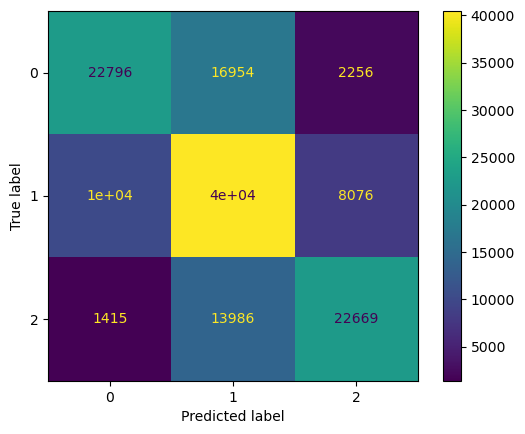

In [17]:
# getting a heatmap of the confusion matrix
ConfusionMatrixDisplay.from_estimator(log_reg_model_exp, X_test, y_test)

Now to get the classification report to check the recall and precision scores.

In [18]:
# getting the classification report
y_pred = log_reg_model_exp.predict(X_test)
class_report = classification_report(y_test, y_pred)

# printing the classification report
print(class_report)

              precision    recall  f1-score   support

           0       0.66      0.54      0.60     42006
           1       0.57      0.69      0.62     58779
           2       0.69      0.60      0.64     38070

    accuracy                           0.62    138855
   macro avg       0.64      0.61      0.62    138855
weighted avg       0.63      0.62      0.62    138855



We won't analyse these as the model is just for the experimental data. 

#### Influential factors

Now we will set up a dataframe that contains the most inflential factors in predicting class 0, which we will deem the most important class to predict, since anyone given a medical urgency score of 0 is in most need of medical care. 

In [17]:
# setting up a series to plot most influential factors in predicting class 0
most_inf_2_pos = pd.DataFrame(log_reg_model_exp.best_estimator_['log_reg'].coef_, columns = X_exp.columns).iloc[0, :].sort_values(ascending=False).head(5)
most_inf_2_neg = pd.DataFrame(log_reg_model_exp.best_estimator_['log_reg'].coef_, columns = X_exp.columns).iloc[0, :].sort_values(ascending=False).tail(5)
most_inf = pd.DataFrame(pd.concat([most_inf_2_pos, most_inf_2_neg]))
most_inf.reset_index(inplace=True)

# renaming columns and adding an effect column that will aid in visualisation
most_inf.rename(columns={'index': 'Attribute', 0: 'Odds ratio multiplier class 0'}, inplace=True)
most_inf['Effect'] = 'none'


We will define a function that makes the 'Effect' column in the dataframe of influential factors 'positive' if increasing that variable results in an increase in odds ratio of getting class 0, and 'negative if the opposite is true. It will mean we can colour the attributes that hacve a negative influence a different colour to those that have a positive influence.

In [26]:
# defining the function described above
def sign(mult):
    if mult > 0:
        return('positive')
    else:
        return('negative')

Now let's apply the function.

In [20]:
# appying the function to the 'Effect' column
most_inf['Effect'] = most_inf['Odds ratio multiplier class 0'].apply(sign)

Now that we have the dataframe of influential factors as desired, we are ready to plot the factors in a bar chart.

In [28]:
# plotting the bar chart
fig = px.bar(most_inf, x='Odds ratio multiplier class 0', y='Attribute', orientation='h', color='Effect')
fig.update_layout(title_text='Most influential factors to medical urgency', title_x=0.5)
fig.show()

We won't read too much into this now, as the results are just on the experimental data. We will go into the details when we run the model on the remainder set.

### Real model

In [4]:
# setting up the grid search model 
gridsearch_model_log_reg_opt = GridSearchCV(pipe, param_grid=params, cv=5)


In [5]:
gridsearch_model_log_reg_opt.fit(X_rem, y_rem)